<a href="https://colab.research.google.com/github/JosepRoo/MNA/blob/main/Equipo39_semana6y7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof. Luis Eduardo Falcón Morales

### **Actividad Semanas 6 y 7 - Tarea colaborativa**

### Modelado de tópicos: LSI / LDA.

### **EQUIPO 39**

*   Josep Romagosa Llorden - **A01374637**
*   Herbert Joadan Romero Villarreal - **A01794199**
*   Eduardo Rodriguez Ramirez - **A01794892**
*   Rodrigo Ildefonso Roman Guzman - **A01794225**
*   Luis Fernando Rojas Marta - **A00757351**

Importacion de librerias y edscarga de stopwordds antes de comenzar a desarrollar la actividad.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### **1. Cargar el archivo**

Descarga el archivo noticiasTopicModeling.txt que se encuentra en Canvas. Este archivo consiste en 5658 noticias de varios periódicos de España. El archivo de texto es una lista en el siguiente formato:
[{“titular”:”Encabezado“, “texto”:”Cuerpo”}, ... , {“titular”:”Encabezado”,”texto”:”Cuerpo”}]
Donde “titular” es el encabezado de la noticia y “texto” es el cuerpo del texto de dicha noticia. En particular en esta actividad trabajarás solamente con los cuerpos de las noticias, sin incluir los encabezados. Carga dicho archivo y genera un DataFrame de Pandas llamado “df” y que contiene una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.

In [ ]:
#Descargamos el archivo previamente almacenado en nuestro Drive de Google
dfn = pd.read_json('/content/drive/Shared drives/NLP/semana6y7/noticiasTopicModeling.txt', lines=False, encoding='utf-8')

#Conservamos unicamente la informacion de la columna Texto
df = dfn[['texto']].copy()

#Renombramos el nombre de la columna a noticia
df.rename(columns={'texto':'noticia'}, inplace=True)

In [ ]:
#corroboramos que df tenga los 5,658 renglones que se comentan en la actividad y visualizamos los primeros 5 elementos de df
print(df.shape)
df.head()

(5658, 1)


,noticia
0,"""España ha dejado de ser católica"", decía Manu..."
1,El clima de crispación social en Ceuta ha lleg...
2,El Gobierno ha alegado la suspensión de plazos...
3,"Puedes mandar tu pregunta, sugerencia o queja ..."
4,Panamá debe entregar esta semana a la Corte In...


###**2. Proceso de Limpieza**
Realiza un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado para texto en español. Recuerda que el objetivo es identificar los tokens (palabras) que describan mejor la distribución de cada tema.
NOTA: Recuerda que esta es una técnica no supervisada, por lo que no requerimos hacer una partición de los datos.

In [ ]:
# Obtenemos la lista de stopwords en español
stops = stopwords.words('spanish')

def clean_tok(doc):
  # Eliminamos los signos de puntuación, caracteres especiales y números
  tokens = re.sub(r'[^A-Za-záéíóúüñ\s]', ' ', doc).strip()

  # Eliminamos espacios en blanco adicionales y convierte a minúsculas
  tokens = ' '.join(re.findall(r'\b\w+\b', tokens.lower()))

  # Tokenizacion por palabras, elimina stopwords y palabras de longitud menor a 2
  tokens = [w for w in tokens.split() if w not in stops and len(w) > 2]

  return tokens

In [ ]:
#Almacenamos los resultados de la limpieza en una nueva variable
clean_doc = [clean_tok(x) for x in df['noticia']]

In [ ]:
#Observamos nuevamente los primeros elementos del DF preprocesado
print(clean_doc[0][0:20])

['españa', 'dejado', 'ser', 'católica', 'decía', 'manuel', 'azaña', 'comienzo', 'segunda', 'república', 'aquel', 'congreso', 'diputados', 'aprobó', 'leyes', 'laicistas', 'metáfora', 'dejó', 'ser', 'católica']


Cuando trabajamos con modelos supervisados debemos de reservar un conjunto para entrenamiento y validación y otro para pruebas. El modelo se entrena con el primer conjunto y se valida su eficiencia utilizando las etiquetas dadas, una vez que estemos conformes con el rendimiento del modelo, se utiliza el conjunto de pruebas para corroborar la eficiencia del modelo.

Sin embargo, en este caso vamos a utilizar un modelo no supervisado que va a realizar un análisis para extraer el tema y subtemas de un texto, al no haber etiquetas para corroborar, no necesitamos reservar un conjunto para pruebas, y debe de entrenarse con la mayor cantidad de información posible.

# **Parte 1: Indexación semántica latente (LSI):**

### **3. Matriz Tf-Idf**
Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens. ¿Cuál es el significado de cada renglón? ¿Y el significado de cada columna?

In [ ]:
#Importacion de Librerias para realizar la matriz
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Construimos vocabulario de palabras con base al conteo de tokens
midiccionario = Counter()

for k in range(len(clean_doc)):
  midiccionario.update(clean_doc[k])

In [ ]:
print('Longitud del diccionario:', len(midiccionario))
print(midiccionario.most_common(10))

Longitud del diccionario: 100089
[('gobierno', 10326), ('años', 7545), ('dos', 7400), ('personas', 7068), ('coronavirus', 6787), ('ser', 6652), ('madrid', 6173), ('según', 6050), ('españa', 6014), ('parte', 5957)]


In [ ]:
# Convertimos cada renglón en un solo string

clean_doc = [' '.join(x) for x in clean_doc]

In [ ]:
# Obtenemos nuestro vocabulario de tokens
vocab = list(midiccionario.keys())

# Creamos instancia de TfidfVectorizer con nuestro vocabulario
tfidfvectorizer = TfidfVectorizer(vocabulary=vocab,
                                  norm=None,
                                  max_df=0.80,  # vamos a ignorar las palabras con frecuencia mayor a 80% suponiendo que son conectores
                                  min_df=10,     # vamos a ignorar las palabras que aparezcan menos de 10 veces
                                  strip_accents='unicode') #Eliminamos los acentos si es que los hay (aunque leímos que unicode era más lento que ascii, también
                                                #leímos que garantiza la remoción))

matriz_tfidf = tfidfvectorizer.fit_transform(clean_doc)

tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(data = matriz_tfidf.toarray(), columns = tfidf_tokens)

# Imprimimos los primeros 5 renglones
print(df_tfidf.iloc[0:5, 0:])
print(df_tfidf.shape)

   españa    dejado       ser  católica  decía    manuel  azaña  comienzo  \
0     0.0  9.529243  8.220060       0.0    0.0  6.611896    0.0  4.327796   
1     0.0  0.000000  1.644012       0.0    0.0  0.000000    0.0  0.000000   
2     0.0  0.000000  1.644012       0.0    0.0  0.000000    0.0  0.000000   
3     0.0  0.000000  4.932036       0.0    0.0  3.305948    0.0  0.000000   
4     0.0  0.000000  1.644012       0.0    0.0  0.000000    0.0  0.000000   

   segunda  república  ...  cicala  venerd  anarchici  mainl  hartmann  \
0  2.83528        0.0  ...     0.0     0.0        0.0    0.0       0.0   
1  0.00000        0.0  ...     0.0     0.0        0.0    0.0       0.0   
2  0.00000        0.0  ...     0.0     0.0        0.0    0.0       0.0   
3  0.00000        0.0  ...     0.0     0.0        0.0    0.0       0.0   
4  0.00000        0.0  ...     0.0     0.0        0.0    0.0       0.0   

   polvorientos  aqueos  iliada  rebajarla  adaya  
0           0.0     0.0     0.0        0

**¿Cuál es el significado de cada renglón?**

* Cada renglón en nuestra matriz tf-idf representa el cuerpo de una noticia, o bien, cada renglón es un documento.

**¿Y el significado de cada columna?**

* Cada columna representa un token, es decir, una palabra que aparece en el cuerpo de las noticias. El número de columnas es igual al número de tokens que aparecen en todos los documentos.

### **4. Descomposición en valores singulares (SVD)**
Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gráfico de la importancia relativa de estas.

In [ ]:
#Importamos librerias necesarias
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Definimos la cantidad de componentes
num_comp = 10

# Descomposición SVD con 100 iteraciones
SVD = TruncatedSVD(n_components=num_comp, n_iter=100, random_state=42)
sv_mtx = SVD.fit_transform(matriz_tfidf)

# Obtenemos la matriz 'sigma' diagonal con los valores singulares
Sigma = SVD.singular_values_
sv_mtx.shape

(5658, 10)

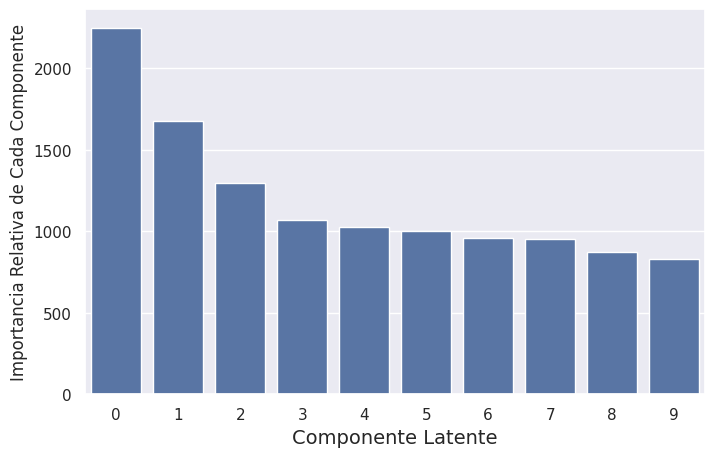

In [ ]:
# Gráfica de importancia relativa de cada componente

 # Establecer tamaño de la figura
sns.set(rc={'figure.figsize':(8, 5)})
chart = sns.barplot(x=list(range(len(Sigma))), y=Sigma)
chart.set_xlabel('Componente Latente', fontdict={'size': 14})  # Establecer etiqueta y formato del eje x
chart.set_ylabel('Importancia Relativa de Cada Componente', fontdict={'size': 12})  # Establecer etiqueta y formato del eje y
plt.show()

### **5. Obtener la matriz tokens-temas (term-topic) a partir de la matriz $𝑉^T$ de la descomposición SVD.**
Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.

In [ ]:
# Obtener la matriz V.T
V_T = SVD.components_.T

term_topic = V_T

term_topic.shape

(100089, 10)

In [ ]:
# Obtener los nombres de los términos
term_names = list(tfidfvectorizer.get_feature_names_out())

# Construir dataframe de la matriz term-topic
term_topic_mtx = pd.DataFrame(data=term_topic, index=term_names,
                              columns=['Concepto_Latente_'+str(i) for i in range(0, num_comp)])

print(term_topic_mtx.shape)

(100089, 10)


In [ ]:
# Imprimir los primeros 5 renglones
term_topic_mtx.head(5)

,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9
españa,-1.502569e-31,1.701366e-17,-3.886196e-16,1.379603e-15,3.660463e-15,-2.279717e-15,8.077107e-17,4.806203e-15,-1.219482e-15,3.415670e-16
dejado,1.735562e-02,-2.588122e-03,-3.092085e-03,-5.085078e-03,4.106559e-03,1.657175e-04,-5.861199e-03,3.695884e-03,4.206000e-04,-9.192639e-03
ser,8.986148e-02,4.896504e-03,1.000272e-02,1.213879e-02,-1.863750e-02,-5.555311e-02,3.049787e-02,-4.821065e-03,-3.896481e-02,-1.572872e-02
católica,-1.728400e-32,8.956499e-33,7.179904e-31,2.035081e-20,-6.572709e-16,4.637150e-16,1.672890e-16,-3.497588e-16,6.624750e-17,-1.784558e-16
decía,-8.994551e-32,1.161367e-31,-1.242259e-30,-1.115739e-21,9.132708e-18,5.604316e-16,2.885396e-16,-6.968911e-17,1.084084e-16,1.186901e-16


### **6. Graficar 10 tokens más importantes**

 Con base a la cantidad de conceptos latentes que determinaste en el ejercicio anterior, obtener cada uno de sus gráficos con sus 10 términos/tokens más importantes. ¿Cómo describirías cada uno de dichos conceptos latentes? ¿Se identifican claramente las temáticas de cada uno de ellos?

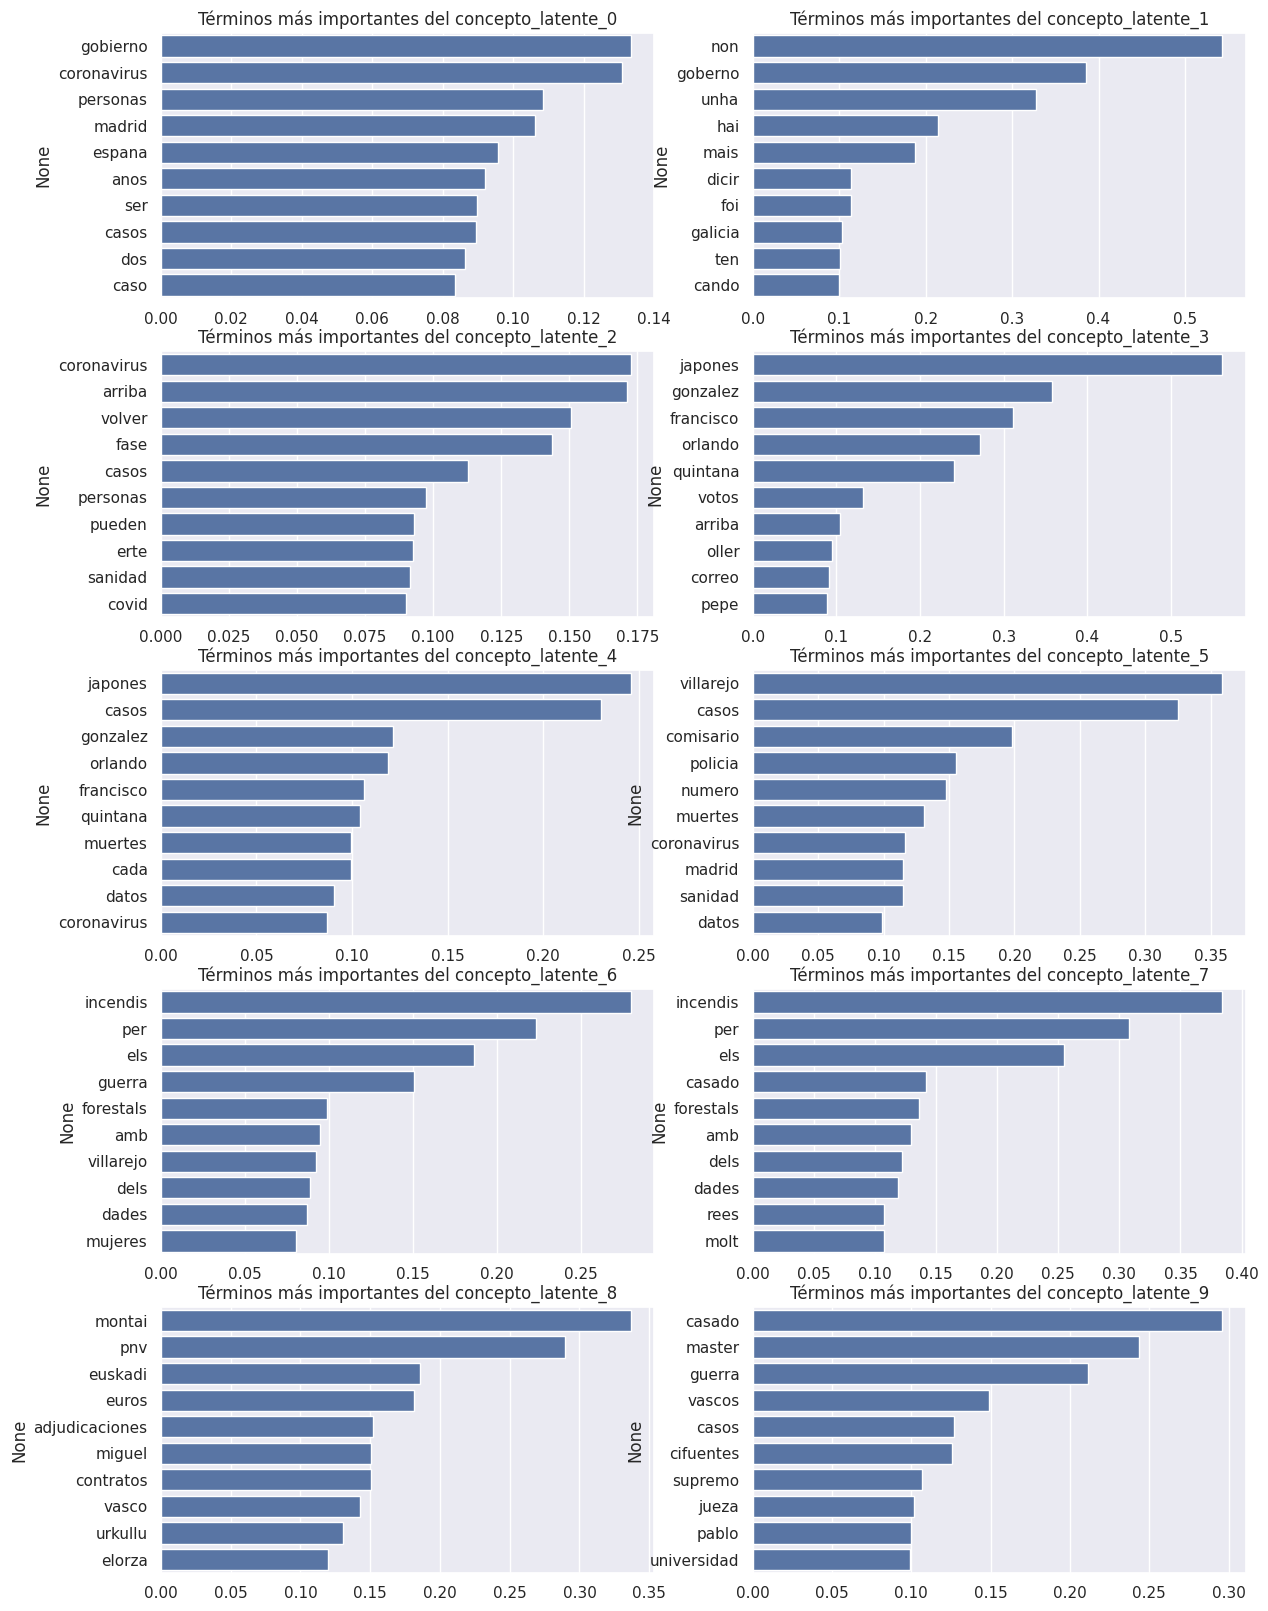

In [ ]:
#Definimos la cantidad de conceptos latentes a mostrar
top = 10

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))

#Impresion de terminos
for i in range(0, num_comp):
    data = term_topic_mtx['Concepto_Latente_'+str(i)].sort_values(ascending=False)
    top_term_mtx = data[:top]
    plt.subplot(5, 2, i + 1)
    plt.title('Términos más importantes del concepto_latente_'+str(i))
    ax = sns.barplot(x=top_term_mtx.values, y=top_term_mtx.index)

plt.show()

**¿Cómo describirías cada uno de dichos conceptos latentes?**

* Estos conceptos latentes estan mostrando las tematicas mas recurrentes dentro del corpus de las noticias. Tras revisarlos, se pueden identificar temas relacionados a politica, salud, economia, entre otros mas.

* Algunos de estos conceptos latentes tienen tematicas similares con otros mismos conceptos ya que tienen varios terminos similares.

**¿Se identifican claramente las temáticas de cada uno de ellos?**

* Si, ya que la mayoria de los terminos relacionados con cada concepto parecen estar bien agrupados al rededor de tematicas especificas, demostrando que son coherentes entre si.

* Por ejemplo, en los casos de los conceptos 0, 2, 4, y 5, se incluyen terminos como "datos", "casos", "coronavirus", "personas", por lo cual es claro que el tema esta relacionado con la salud. Y asi se pueden identificar otros conceptos mas relacionados con "gobierno/politica", "ecologia", entre otros.


# **Parte 2: Asignación de Dirichlet Latente (LDA)**

### **7. Utiliza la librería Gensim para implementar ahora la técnica de LDA.**
Revisa la documentación correspondiente y aplica de preferencia el modelo paralelizable.
* https://radimrehurek.com/gensim/models/ldamodel.html
* https://radimrehurek.com/gensim/models/ldamulticore.html


In [ ]:
!pip install gensim

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# Generamos nuevamente documentos tokenizdos
docs = [clean_tok(x) for x in df['noticia']]

In [ ]:
# Creamos diccionario
mi_dicc = corpora.Dictionary(docs)

# Bolsa de palabras
bow = [mi_dicc.doc2bow(doc) for doc in docs]

In [ ]:
from gensim.models.ldamulticore import LdaMulticore

In [ ]:
# generamos el diccionario:

id2word = corpora.Dictionary(docs)

for id in range(5):
    print(id2word[id])

abascal
abril
actores
afd
ahora


In [ ]:
# Generamos el corpus con las tuplas (índice, frecuencia):

corpus = [id2word.doc2bow(doc) for doc in docs]

In [ ]:
# 1. Entrenamos modelo LDA paralelizable (multicore)
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       chunksize=100,
                                       passes=10,
                                       alpha=0.5,
                                       eta=0.5
                                       )

In [ ]:
# Imprimimos los 10 temas con sus 10 principales palabras
lda_model.print_topics(num_topics=10, num_words=10)

[(0,
  '0.009*"gobierno" + 0.005*"política" + 0.005*"partido" + 0.004*"caso" + 0.004*"dos" + 0.004*"madrid" + 0.003*"presidente" + 0.003*"según" + 0.003*"podemos" + 0.003*"tras"'),
 (1,
  '0.013*"galicia" + 0.010*"máster" + 0.008*"cifuentes" + 0.007*"universidad" + 0.007*"feijóo" + 0.006*"xunta" + 0.004*"gallego" + 0.004*"alumnos" + 0.004*"urjc" + 0.003*"asignaturas"'),
 (2,
  '0.006*"guerra" + 0.005*"cine" + 0.004*"historia" + 0.004*"trump" + 0.003*"the" + 0.003*"cultura" + 0.003*"película" + 0.003*"dos" + 0.003*"obra" + 0.002*"memoria"'),
 (3,
  '0.011*"millones" + 0.009*"euros" + 0.005*"año" + 0.005*"empresas" + 0.005*"economía" + 0.004*"europea" + 0.003*"españa" + 0.003*"empresa" + 0.003*"según" + 0.003*"sector"'),
 (4,
  '0.003*"per" + 0.002*"lukashenko" + 0.002*"ncia" + 0.001*"val" + 0.001*"els" + 0.001*"bielorrusia" + 0.001*"amb" + 0.001*"minsk" + 0.001*"ria" + 0.001*"segur"'),
 (5,
  '0.010*"coronavirus" + 0.007*"personas" + 0.006*"casos" + 0.005*"pandemia" + 0.004*"datos" + 0.

In [ ]:
# 2. Probamos modelo LDA con 8 temas
lda_model_ = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8,
                                       chunksize=50,
                                       passes=10,
                                       alpha=0.5,
                                       eta=0.5
                                       )

In [ ]:
lda_model_.print_topics(num_topics=8, num_words=10)

[(0,
  '0.016*"partido" + 0.012*"podemos" + 0.009*"psoe" + 0.009*"elecciones" + 0.008*"casado" + 0.008*"sánchez" + 0.008*"ciudadanos" + 0.008*"vox" + 0.007*"política" + 0.006*"gobierno"'),
 (1,
  '0.007*"guerra" + 0.005*"trump" + 0.004*"unidos" + 0.004*"país" + 0.003*"eeuu" + 0.003*"israel" + 0.003*"memoria" + 0.003*"norte" + 0.003*"internacional" + 0.002*"efe"'),
 (2,
  '0.019*"coronavirus" + 0.011*"casos" + 0.009*"personas" + 0.008*"covid" + 0.008*"datos" + 0.007*"pandemia" + 0.006*"cada" + 0.006*"salud" + 0.006*"días" + 0.005*"información"'),
 (3,
  '0.007*"caso" + 0.005*"tribunal" + 0.005*"investigación" + 0.004*"policía" + 0.004*"dos" + 0.004*"según" + 0.004*"juan" + 0.003*"juez" + 0.003*"política" + 0.003*"fiscalía"'),
 (4,
  '0.006*"años" + 0.005*"ser" + 0.003*"solo" + 0.003*"mujeres" + 0.003*"puede" + 0.003*"vida" + 0.003*"mundo" + 0.003*"hace" + 0.003*"cómo" + 0.003*"vez"'),
 (5,
  '0.011*"gobierno" + 0.006*"madrid" + 0.004*"etiquetas" + 0.004*"según" + 0.004*"parte" + 0.003*"

### **8. Cantidad de tópicos adecuada**

**Con base a esta técnica ¿qué cantidad de tópicos consideras que es la más adecuada? Compara tus resultados con el método LSI.**

* En base al LDA, parece que el modelo con 10 topicos proporciona una separacion clara y significativa de temas, cubriendo ampliamente las diferentes areas del corpus de noticias.

* Comparado con el LSI, donde la dimension de los temas tambien es muy importante, LDA ofrece una representacion más clara y distinguible de los toppicos, posiblemente debido a su capacidad de modelar explicitamente la distribucion de palabras. LSI, aunque resulta util para identificar patrones latentes, en esta actividad se demostro que puede mostrar temas superpuestos.

**¿Qué encuentras de coincidencias y diferencias?**

* Entre LDA y LSI, los dos identifican los temas relevantes dentro del corpus de noticias. Sin embargo, LDA tiende a ser mas especifico en la identificacion de topicos debido a su enfoque mas relacionado a probabilidad. Mientras que LSI puede mezclar varios temas en un solo componente latente debido a basarse en tecnicas de reduccion de dimensionalidad. Por lo cual, LDA demuestra ser mejor para la interpretacion y distincion de topicos.


**¿Cuál consideras puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a considerar?**

* Despues del analisis, y tras observar la relevancia de los temas de los topicos obtenidos, parece que el uso de 10 topicos en LDA es la tecnica mas adecuada para este conjunto de datos. Esta cantidad no solo nos da una amplia variedad de temas relevantes, sino que evita la generalizacion o division excesiva de los temas.

### **9. Conclusión final**

* El trabajo y analisis de topicos mediante LDA y LSI nos ha permitido identificar y caracterizar los principales temas dentro de un conjunto de noticias de varios periodicos españoles. El modelado de topicos no solo ayuda a entender las principales ramas y temas principales en los medios de comunicacion, sino que tambien nos da herramientas para la clasificación automatica de documentos y la extraccion de informacion relevante de grandes corpus de texto. Para esta y futuras aplicaciones, se puede ajustar el numero de topicos y tambien experimentar con diferentes configuraciones que nos puedan permitir obtener insights adicionales y quizas mejorar la precision de este modelado de temas.